In [1]:
import zipfile
import os, glob
import numpy as np
import nibabel as nib
from nibabel.processing import resample_from_to
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

In [2]:
def unzip_to_folder(zip_path):
    folder_name = os.path.splitext(os.path.basename(zip_path))[0]
    os.makedirs(folder_name, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder_name)
    print(f"Unzipped {zip_path} → {folder_name}/")
    return folder_name

In [3]:
unzip_to_folder("/content/Final_tvt_Dataset_v1.zip")

Unzipped /content/Final_tvt_Dataset_v1.zip → Final_tvt_Dataset_v1/


'Final_tvt_Dataset_v1'

In [4]:
import os
import pandas as pd

label_dir = "Final_tvt_Dataset_v1/train/labels"
csv_path  = "/content/strat_subset.csv"


df = pd.read_csv(csv_path)
df["ID_num"] = df["ID"].str.split("_").str[1]

label_files = [f for f in os.listdir(label_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
label_ids = [f.split(".nii")[0] for f in label_files]
label_ids_set = set(label_ids)


train_csv = df[df["ID_num"].isin(label_ids_set)].copy()

print("All CSV unique ID_num:", df["ID_num"].nunique())
print("Train label IDs:", len(label_ids_set))
print("Filtered train_csv unique ID_num:", train_csv["ID_num"].nunique())
print("Filtered train_csv rows:", len(train_csv))

train_csv["_mr"] = df["ID"].str.split("_").str[-1]
train_csv = (train_csv.sort_values(["ID_num", "_mr"])
                      .drop_duplicates(subset="ID_num", keep="first")
                      .drop(columns=["_mr"]))

print("After dedupe -> one row per subject:")
print("  train_csv unique ID_num:", train_csv["ID_num"].nunique())
print("  rows:", len(train_csv))


csv_ids = set(train_csv["ID_num"])
print("CSV minus labels (should be empty):", csv_ids - label_ids_set)
print("Labels minus CSV (should be empty):", label_ids_set - csv_ids)


All CSV unique ID_num: 104
Train label IDs: 81
Filtered train_csv unique ID_num: 81
Filtered train_csv rows: 81
After dedupe -> one row per subject:
  train_csv unique ID_num: 81
  rows: 81
CSV minus labels (should be empty): set()
Labels minus CSV (should be empty): set()


In [5]:
import os
import pandas as pd

label_dir = "Final_tvt_Dataset_v1/val/labels"
csv_path  = "/content/strat_subset.csv"


df = pd.read_csv(csv_path)
df["ID_num"] = df["ID"].str.split("_").str[1]


label_files = [f for f in os.listdir(label_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
label_ids = [f.split(".nii")[0] for f in label_files]
label_ids_set = set(label_ids)


val_csv = df[df["ID_num"].isin(label_ids_set)].copy()

print("All CSV unique ID_num:", df["ID_num"].nunique())
print("Train label IDs:", len(label_ids_set))
print("Filtered train_csv unique ID_num:", val_csv["ID_num"].nunique())
print("Filtered train_csv rows:", len(val_csv))


val_csv["_mr"] = df["ID"].str.split("_").str[-1]
val_csv = (val_csv.sort_values(["ID_num", "_mr"])
                      .drop_duplicates(subset="ID_num", keep="first")
                      .drop(columns=["_mr"]))

print("After dedupe -> one row per subject:")
print("  train_csv unique ID_num:", val_csv["ID_num"].nunique())
print("  rows:", len(val_csv))


csv_ids = set(val_csv["ID_num"])
print("CSV minus labels (should be empty):", csv_ids - label_ids_set)
print("Labels minus CSV (should be empty):", label_ids_set - csv_ids)


All CSV unique ID_num: 104
Train label IDs: 10
Filtered train_csv unique ID_num: 10
Filtered train_csv rows: 10
After dedupe -> one row per subject:
  train_csv unique ID_num: 10
  rows: 10
CSV minus labels (should be empty): set()
Labels minus CSV (should be empty): set()


In [6]:
import os
import pandas as pd

label_dir = "Final_tvt_Dataset_v1/test/labels"
csv_path  = "/content/strat_subset.csv"


df = pd.read_csv(csv_path)
df["ID_num"] = df["ID"].str.split("_").str[1]


label_files = [f for f in os.listdir(label_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]
label_ids = [f.split(".nii")[0] for f in label_files]
label_ids_set = set(label_ids)


test_csv = df[df["ID_num"].isin(label_ids_set)].copy()

print("All CSV unique ID_num:", df["ID_num"].nunique())
print("Train label IDs:", len(label_ids_set))
print("Filtered train_csv unique ID_num:", test_csv["ID_num"].nunique())
print("Filtered train_csv rows:", len(test_csv))


test_csv["_mr"] = df["ID"].str.split("_").str[-1]
test_csv = (test_csv.sort_values(["ID_num", "_mr"])
                      .drop_duplicates(subset="ID_num", keep="first")
                      .drop(columns=["_mr"]))

print("After dedupe -> one row per subject:")
print("  train_csv unique ID_num:", test_csv["ID_num"].nunique())
print("  rows:", len(test_csv))

csv_ids = set(test_csv["ID_num"])
print("CSV minus labels (should be empty):", csv_ids - label_ids_set)
print("Labels minus CSV (should be empty):", label_ids_set - csv_ids)


All CSV unique ID_num: 104
Train label IDs: 11
Filtered train_csv unique ID_num: 11
Filtered train_csv rows: 11
After dedupe -> one row per subject:
  train_csv unique ID_num: 11
  rows: 11
CSV minus labels (should be empty): set()
Labels minus CSV (should be empty): set()


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

def preprocess_csv(df, le_dict=None, fit=True):

    if "ID" in df.columns:
        df = df.drop(columns=["ID"])

    cat_cols = ["M/F", "Hand"]

    if le_dict is None:
        le_dict = {}

    for c in cat_cols:
        if fit:
            le = LabelEncoder()
            df[c] = le.fit_transform(df[c].astype(str))
            le_dict[c] = le
        else:
            df[c] = le_dict[c].transform(df[c].astype(str))

    cdr_map = {
        0.0: 'Healthy',
        2.0: 'Very Mild',
        1.0: 'Mild',
        0.5: 'Moderate'
    }
    df['CDR_Label'] = df['CDR'].map(cdr_map)

    fixed_label_order = ['Healthy', 'Very Mild', 'Mild', 'Moderate']

    if fit:
        le_cdr = LabelEncoder()
        le_cdr.classes_ = np.array(fixed_label_order)  # enforce order
        le_dict['CDR'] = le_cdr

    le_cdr = le_dict['CDR']
    df['CDR_Class'] = df['CDR_Label'].map(
        {label: i for i, label in enumerate(le_cdr.classes_)}
    )

    print(f"Custom fixed classes: {dict(zip(le_cdr.classes_, range(len(le_cdr.classes_))))}")
    return df, le_dict


In [8]:

train_df, encoders = preprocess_csv(train_csv, fit=True)


val_df, _ = preprocess_csv(val_csv, le_dict=encoders, fit=False)

test_df, _ = preprocess_csv(test_csv, le_dict=encoders, fit=False)


print(train_df.head())
print(val_df.head())


Custom fixed classes: {np.str_('Healthy'): 0, np.str_('Very Mild'): 1, np.str_('Mild'): 2, np.str_('Moderate'): 3}
Custom fixed classes: {np.str_('Healthy'): 0, np.str_('Very Mild'): 1, np.str_('Mild'): 2, np.str_('Moderate'): 3}
Custom fixed classes: {np.str_('Healthy'): 0, np.str_('Very Mild'): 1, np.str_('Mild'): 2, np.str_('Moderate'): 3}
    M/F  Hand  Age  MMSE  CDR  eTIV   nWBV    ASF  Age_cat ID_num CDR_Label  \
41    1     0   74  30.0  0.0  1636  0.689  1.073        3   0010   Healthy   
3     1     0   89  28.0  0.0  1631  0.682  1.076        4   0032   Healthy   
18    1     0   27  29.4  0.0  1313  0.842  1.336        1   0037   Healthy   
99    0     0   62  28.0  0.5  1350  0.758  1.300        3   0041  Moderate   
27    1     0   21  29.4  0.0  1511  0.846  1.162        1   0043   Healthy   

    CDR_Class  
41          0  
3           0  
18          0  
99          3  
27          0  
    M/F  Hand  Age  MMSE  CDR  eTIV   nWBV    ASF  Age_cat ID_num CDR_Label  \
34   

In [9]:
train_df

,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF,Age_cat,ID_num,CDR_Label,CDR_Class
41,1,0,74,30.0,0.0,1636,0.689,1.073,3,0010,Healthy,0
3,1,0,89,28.0,0.0,1631,0.682,1.076,4,0032,Healthy,0
18,1,0,27,29.4,0.0,1313,0.842,1.336,1,0037,Healthy,0
99,0,0,62,28.0,0.5,1350,0.758,1.300,3,0041,Moderate,3
27,1,0,21,29.4,0.0,1511,0.846,1.162,1,0043,Healthy,0
...,...,...,...,...,...,...,...,...,...,...,...,...
28,0,0,22,29.4,0.0,1444,0.853,1.216,1,0437,Healthy,0
54,1,0,21,29.4,0.0,1438,0.844,1.221,1,0439,Healthy,0
29,1,0,86,27.0,0.5,1320,0.723,1.329,4,0440,Moderate,3
93,1,0,81,29.0,0.5,1647,0.721,1.066,3,0441,Moderate,3


In [10]:
val_df

,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF,Age_cat,ID_num,CDR_Label,CDR_Class
34,0,0,81,30.0,0.0,1664,0.679,1.055,3,0013,Healthy,0
10,1,0,25,29.4,0.0,1759,0.783,0.998,1,0117,Healthy,0
57,1,0,30,29.4,0.0,1538,0.862,1.141,2,0127,Healthy,0
97,0,0,31,29.4,0.0,1294,0.839,1.357,2,0192,Healthy,0
88,1,0,80,28.0,0.5,1506,0.679,1.166,3,0267,Moderate,3
26,0,0,75,26.0,0.5,1355,0.745,1.296,3,0272,Moderate,3
32,1,0,68,30.0,0.5,1556,0.723,1.128,3,0300,Moderate,3
92,0,0,73,29.0,0.0,1123,0.790,1.563,3,0355,Healthy,0
90,0,0,70,30.0,0.0,1361,0.783,1.290,3,0371,Healthy,0
55,1,0,75,20.0,1.0,1613,0.715,1.088,3,0424,Mild,2


In [11]:
test_df

,M/F,Hand,Age,MMSE,CDR,eTIV,nWBV,ASF,Age_cat,ID_num,CDR_Label,CDR_Class
50,0,0,20,29.4,0.0,1505,0.843,1.166,1,0009,Healthy,0
33,0,0,49,30.0,0.0,1459,0.808,1.203,2,0071,Healthy,0
79,0,0,47,30.0,0.0,1311,0.835,1.339,2,0086,Healthy,0
80,1,0,18,29.4,0.0,1514,0.846,1.159,1,0129,Healthy,0
9,0,0,21,29.4,0.0,1421,0.835,1.235,1,0191,Healthy,0
1,0,0,22,29.4,0.0,1328,0.842,1.321,1,0209,Healthy,0
69,1,0,22,29.4,0.0,1570,0.831,1.118,1,0302,Healthy,0
7,0,0,78,15.0,2.0,1401,0.703,1.253,3,0308,Very Mild,1
40,1,0,65,29.0,0.0,1362,0.839,1.289,3,0358,Healthy,0
38,0,0,52,30.0,0.0,1431,0.814,1.226,2,0443,Healthy,0


In [ ]:
encoders

{'M/F': LabelEncoder(), 'Hand': LabelEncoder(), 'CDR': LabelEncoder()}

In [12]:
def conv_block(x, filters, dropout_rate=0.2):
    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Conv3D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


def attention_gate(x, g, inter_channels):
    theta_x = layers.Conv3D(inter_channels, 2, strides=2, padding='same')(x)
    phi_g = layers.Conv3D(inter_channels, 1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.ReLU()(add)
    psi = layers.Conv3D(1, 1, padding='same', activation='sigmoid')(act)
    upsampled_psi = layers.UpSampling3D(size=(2,2,2))(psi)
    attn_out = layers.Multiply()([x, upsampled_psi])
    return attn_out


def build_att_unet3d_with_class(
    input_shape=(128,128,128,1),
    tabular_dim=0,
    base_filters=32,
    class_hidden=(128,64),
    dropout_rate=0.2,
    num_classes=4
):

    img_in = layers.Input(shape=input_shape, name="img_input")


    c1 = conv_block(img_in, base_filters, dropout_rate)
    p1 = layers.MaxPooling3D((2,2,2))(c1)

    c2 = conv_block(p1, base_filters*2, dropout_rate)
    p2 = layers.MaxPooling3D((2,2,2))(c2)

    c3 = conv_block(p2, base_filters*4, dropout_rate)
    p3 = layers.MaxPooling3D((2,2,2))(c3)

    c4 = conv_block(p3, base_filters*8, dropout_rate)
    p4 = layers.MaxPooling3D((2,2,2))(c4)


    bn = conv_block(p4, base_filters*16, dropout_rate)


    bn_vec = layers.GlobalAveragePooling3D(name="bn_gap")(bn)
    inputs = [img_in]

    if tabular_dim and tabular_dim > 0:
        tab_in = layers.Input(shape=(tabular_dim,), name="tab_input")
        inputs.append(tab_in)
        t = layers.Dense(64, activation='relu', name="tab_dense")(tab_in)
        fused = layers.Concatenate(name="fuse_bn_tab")([bn_vec, t])
    else:
        fused = bn_vec

    c = fused
    for i, u in enumerate(class_hidden):
        c = layers.Dense(u, activation='relu', name=f"class_dense_{i+1}")(c)
        c = layers.Dropout(dropout_rate)(c)

    class_out = layers.Dense(num_classes, activation='softmax', name="cdr_class")(c)


    g4 = layers.Conv3D(base_filters*8, 1, padding='same')(bn)
    a4 = attention_gate(c4, g4, base_filters*8)
    u4 = layers.Conv3DTranspose(base_filters*8, 2, strides=2, padding='same')(bn)
    u4 = layers.Concatenate()([u4, a4])
    c5 = conv_block(u4, base_filters*8, dropout_rate)

    g3 = layers.Conv3D(base_filters*4, 1, padding='same')(c5)
    a3 = attention_gate(c3, g3, base_filters*4)
    u3 = layers.Conv3DTranspose(base_filters*4, 2, strides=2, padding='same')(c5)
    u3 = layers.Concatenate()([u3, a3])
    c6 = conv_block(u3, base_filters*4, dropout_rate)

    g2 = layers.Conv3D(base_filters*2, 1, padding='same')(c6)
    a2 = attention_gate(c2, g2, base_filters*2)
    u2 = layers.Conv3DTranspose(base_filters*2, 2, strides=2, padding='same')(c6)
    u2 = layers.Concatenate()([u2, a2])
    c7 = conv_block(u2, base_filters*2, dropout_rate)

    g1 = layers.Conv3D(base_filters, 1, padding='same')(c7)
    a1 = attention_gate(c1, g1, base_filters)
    u1 = layers.Conv3DTranspose(base_filters, 2, strides=2, padding='same')(c7)
    u1 = layers.Concatenate()([u1, a1])
    c8 = conv_block(u1, base_filters, dropout_rate)

    seg_out = layers.Conv3D(1, 1, activation='sigmoid', name="seg")(c8)


    model = models.Model(inputs=inputs, outputs=[seg_out, class_out], name="AttUNet3D_withClass")
    return model


In [13]:
import nibabel as nib
import numpy as np
import tensorflow as tf

CROP_SIZE = (128,128,128)

def load_nifti(path):
    return nib.load(path).get_fdata()

def normalize_image(img, eps=1e-8):
    return (img - np.mean(img)) / (np.std(img) + eps)

def multimodal_generator(img_paths, lbl_paths, ids, df, feature_cols,
                         target_col="CDR_Class", num_classes=4):
    df_indexed = df.set_index("ID_num")

    for img_p, lbl_p, sid in zip(img_paths, lbl_paths, ids):
        img = load_nifti(img_p).astype(np.float32)
        lbl = load_nifti(lbl_p).astype(np.float32)

        img = normalize_image(img)
        lbl = (lbl > 0.5).astype(np.float32)

        img = img[..., np.newaxis]
        lbl = lbl[..., np.newaxis]

        feats = df_indexed.loc[sid, feature_cols].to_numpy().astype(np.float32)

        targ_class = int(df_indexed.loc[sid, target_col])
        targ_onehot = tf.keras.utils.to_categorical(targ_class, num_classes=num_classes).astype(np.float32)

        yield ({"img_input": img, "tab_input": feats},
               {"seg": lbl, "cdr_class": targ_onehot})


In [14]:
import os, glob, tensorflow as tf

def make_multimodal_dataset(img_dir, lbl_dir, df, feature_cols, batch_size=1,
                            shuffle=True, num_classes=4):

    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.nii")))
    lbl_paths = sorted(glob.glob(os.path.join(lbl_dir, "*.nii")))
    ids       = [os.path.basename(p).split(".nii")[0] for p in lbl_paths]  # e.g., "0012"

    ds = tf.data.Dataset.from_generator(
        lambda: multimodal_generator(img_paths, lbl_paths, ids, df, feature_cols,
                                     target_col="CDR_Class", num_classes=num_classes),
        output_signature=(
            {
                "img_input": tf.TensorSpec(shape=(128,128,128,1), dtype=tf.float32),
                "tab_input": tf.TensorSpec(shape=(len(feature_cols),), dtype=tf.float32)
            },
            {
                "seg": tf.TensorSpec(shape=(128,128,128,1), dtype=tf.float32),
                "cdr_class": tf.TensorSpec(shape=(num_classes,), dtype=tf.float32)
            }
        )
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=len(img_paths))

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [ ]:
train_df.columns

Index(['M/F', 'Hand', 'Age', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Age_cat',
       'ID_num', 'CDR_Label', 'CDR_Class'],
      dtype='object')

In [16]:

feature_cols = ["Age", "MMSE", "eTIV", "nWBV", "ASF", "M/F", "Age_cat"]

train_ds = make_multimodal_dataset(
    "Final_tvt_Dataset/train/images",
    "Final_tvt_Dataset/train/labels",
    train_df, feature_cols,
    batch_size=1, shuffle=True, num_classes=4
)

val_ds = make_multimodal_dataset(
    "Final_tvt_Dataset/val/images",
    "Final_tvt_Dataset/val/labels",
    val_df, feature_cols,
    batch_size=1, shuffle=False, num_classes=4
)

x, y = next(iter(train_ds))
print(x["img_input"].shape)
print(x["tab_input"].shape)
print(y["seg"].shape)
print(y["cdr_class"].shape)

(1, 128, 128, 128, 1)
(1, 7)
(1, 128, 128, 128, 1)
(1, 4)


In [17]:


def make_tversky_loss(alpha=0.7, beta=0.3, smooth=1e-6):
    alpha = tf.constant(alpha, dtype=tf.float32)
    beta  = tf.constant(beta, dtype=tf.float32)
    smooth = tf.constant(smooth, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum((1 - y_true_f) * y_pred_f)
        fn = K.sum(y_true_f * (1 - y_pred_f))
        tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
        return 1 - tversky
    return loss


def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)




In [ ]:
import tensorflow as tf, numpy as np, random, os
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


In [18]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def jaccard_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)


def test_and_save_multimodal_classification(
    model,
    test_pairs,
    df_features,
    feature_cols,
    target_col="CDR_Class",
    out_dir="generated",
    threshold=0.5,
    num_classes=4,
    class_names=('Healthy','Very Mild','Mild','Moderate')
):

    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.join(out_dir, "overlays"), exist_ok=True)

    df_idx = df_features.set_index("ID_num")

    dice_scores, jaccard_scores = [], []
    y_true_cls, y_pred_cls = [], []
    subject_results = []

    for img_path, lbl_path in test_pairs:
        sid = os.path.basename(img_path).split(".nii")[0].replace("mri_", "")

        img = nib.load(img_path).get_fdata().astype(np.float32)
        lbl_nii = nib.load(lbl_path)
        lbl = lbl_nii.get_fdata().astype(np.float32)
        lbl = (lbl > 0.5).astype(np.float32)

        img = (img - img.mean()) / (img.std() + 1e-8)

        img_in = img[np.newaxis, ..., np.newaxis]
        feats  = df_idx.loc[sid, feature_cols].to_numpy().astype(np.float32)[np.newaxis, :]
        true_class = int(df_idx.loc[sid, target_col])

        seg_pred, class_pred_logits = model.predict(
            {"img_input": img_in, "tab_input": feats}, verbose=0
        )
        seg_pred = seg_pred[0, ..., 0]
        pred_class = int(np.argmax(class_pred_logits[0]))

        pred_bin = (seg_pred > threshold).astype(np.float32)

        # --- Segmentation metrics ---
        dice = dice_coef_np(lbl, pred_bin)
        jaccard = jaccard_coef_np(lbl, pred_bin)
        dice_scores.append(dice)
        jaccard_scores.append(jaccard)

        # --- Classification metrics ---
        y_true_cls.append(true_class)
        y_pred_cls.append(pred_class)

        subject_results.append({
            "ID_num": sid,
            "True_Class": class_names[true_class],
            "Pred_Class": class_names[pred_class],
            "Dice": dice,
            "Jaccard": jaccard
        })

        pred_nii = nib.Nifti1Image(pred_bin.astype(np.uint8), affine=lbl_nii.affine, header=lbl_nii.header)
        nib.save(pred_nii, os.path.join(out_dir, f"{sid}_pred.nii"))

        mid = img.shape[2] // 2
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        plt.imshow(img[:, :, mid], cmap="gray")
        plt.imshow(lbl[:, :, mid], alpha=0.4, cmap="Reds")
        plt.title(f"GT {sid}"); plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(img[:, :, mid], cmap="gray")
        plt.imshow(pred_bin[:, :, mid], alpha=0.4, cmap="Oranges")
        plt.title(f"Pred {sid}\nDice={dice:.3f}, IoU={jaccard:.3f}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, "overlays", f"{sid}_overlay.png"), dpi=140)
        plt.close()

    mean_dice = float(np.mean(dice_scores)) if dice_scores else float("nan")
    mean_iou  = float(np.mean(jaccard_scores)) if jaccard_scores else float("nan")

    acc = accuracy_score(y_true_cls, y_pred_cls)
    print("Unique true classes:", np.unique(y_true_cls))
    print("Unique predicted classes:", np.unique(y_pred_cls))

    cls_report = classification_report(
        y_true_cls, y_pred_cls,
        target_names=class_names,
        digits=4,
        labels=list(range(num_classes)),
        zero_division=0
    )
    cm = confusion_matrix(y_true_cls, y_pred_cls, labels=list(range(num_classes)))

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"Confusion Matrix (Acc={acc:.3f})")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "confusion_matrix.png"), dpi=150)
    plt.close()

    summary_csv = os.path.join(out_dir, "predictions_summary.csv")
    pd.DataFrame(subject_results).to_csv(summary_csv, index=False)

    print(f"✔ Tested {len(test_pairs)} subjects")
    print(f"Mean Dice:    {mean_dice:.4f}")
    print(f"Mean Jaccard: {mean_iou:.4f}")
    print(f"Classification Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", cls_report)
    print(f"\nPer-subject summary saved to {summary_csv}")

    return {
        "n": len(test_pairs),
        "mean_dice": mean_dice,
        "mean_jaccard": mean_iou,
        "accuracy": acc,
        "confusion_matrix": cm,
        "class_report": cls_report,
        "summary_csv": summary_csv
    }


In [25]:
import tensorflow as tf, numpy as np, random, os
from keras.optimizers import AdamW
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)



dropout_rate = 0.2
alpha, beta = 0.4, 0.6     # Tversky loss balance
BATCH_SIZE = 4
n_train, n_val = 81, 11

steps_per_epoch  = math.ceil(n_train / BATCH_SIZE)
validation_steps = math.ceil(n_val / BATCH_SIZE)


optimizer = AdamW(learning_rate=2e-3, weight_decay=1e-5)


model = build_att_unet3d_with_class(
    input_shape=(128,128,128,1),
    tabular_dim=len(feature_cols),
    base_filters=32,
    dropout_rate=dropout_rate
)


model.compile(
    optimizer=optimizer,
    loss={
        'seg': make_tversky_loss(alpha, beta),
        'cdr_class': 'categorical_crossentropy'
    },
    loss_weights={'seg': 0.9, 'cdr_class': 1.1},
    metrics={
        'seg': [dice_coef, jaccard_coef],
        'cdr_class': ['accuracy']
    }
)


history = model.fit(
    train_ds.repeat(),
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    batch_size=BATCH_SIZE,
    verbose=1
)


val_score = model.evaluate(val_ds, steps=validation_steps, verbose=1)
print(val_score)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - cdr_class_accuracy: 0.6449 - cdr_class_loss: 40.9155 - loss: 45.8919 - seg_dice_coef: 0.0135 - seg_jaccard_coef: 0.0068 - seg_loss: 0.9832 - val_cdr_class_accuracy: 0.0000e+00 - val_cdr_class_loss: 9618.7666 - val_loss: 10581.5361 - val_seg_dice_coef: 0.0077 - val_seg_jaccard_coef: 0.0038 - val_seg_loss: 0.9904
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - cdr_class_accuracy: 0.4370 - cdr_class_loss: 41.9639 - loss: 47.0390 - seg_dice_coef: 0.0190 - seg_jaccard_coef: 0.0096 - seg_loss: 0.9764 - val_cdr_class_accuracy: 0.0000e+00 - val_cdr_class_loss: 2433.5984 - val_loss: 2677.8496 - val_seg_dice_coef: 0.0077 - val_seg_jaccard_coef: 0.0038 - val_seg_loss: 0.9904
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - cdr_class_accuracy: 0.5311 - cdr_class_loss: 26.0067 - loss: 29.4798 - seg_dice_coef: 0.0247 - seg_jaccard_coef: 0.0125 - seg_loss: 0.9693 - val_cdr_class_accuracy: 1.0000 - val_cdr_class_loss: 0.0000e+00 - val_loss: 0.

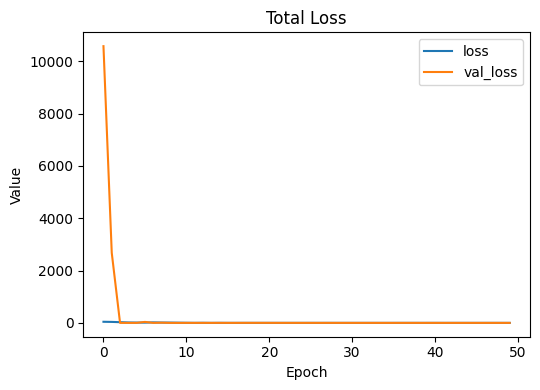

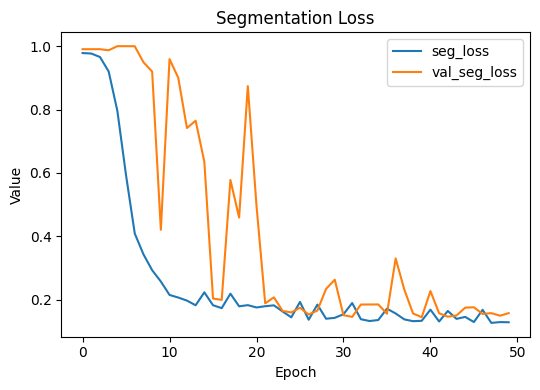

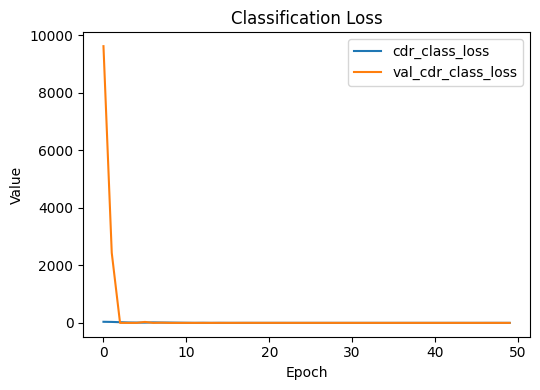

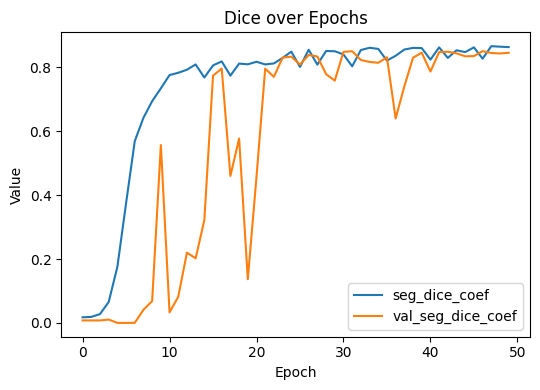

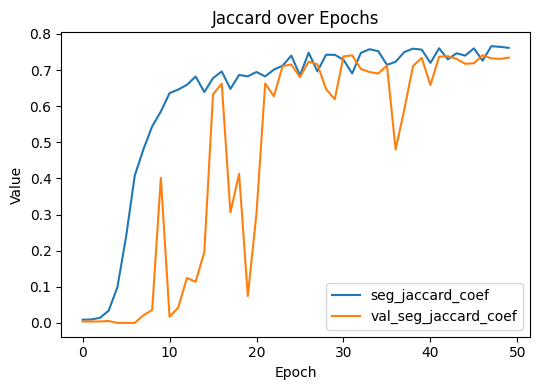

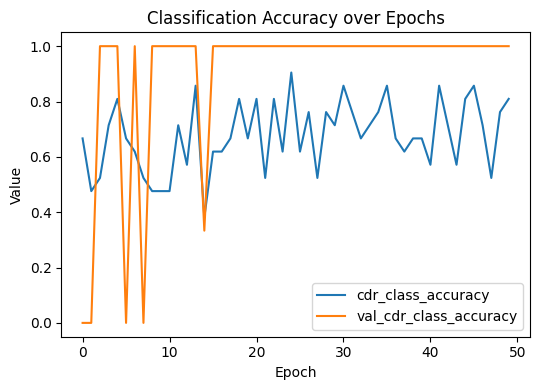

In [26]:

import matplotlib.pyplot as plt

hist = history.history

def plot_curve(keys, title, fname):
    plt.figure(figsize=(5.5,4))
    for k in keys:
        if k in hist:
            plt.plot(hist[k], label=k)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_curve(["loss", "val_loss"], "Total Loss", "loss_total.png")


plot_curve(["seg_loss", "val_seg_loss"], "Segmentation Loss", "loss_seg.png")
plot_curve(["cdr_class_loss", "val_cdr_class_loss"], "Classification Loss", "loss_class.png")


plot_curve(["seg_dice_coef", "val_seg_dice_coef"], "Dice over Epochs", "metric_dice.png")
plot_curve(["seg_jaccard_coef", "val_seg_jaccard_coef"], "Jaccard over Epochs", "metric_jaccard.png")

plot_curve(["cdr_class_accuracy", "val_cdr_class_accuracy"], "Classification Accuracy over Epochs", "metric_acc.png")


In [28]:
import os
import numpy as np

test_img_dir = "Final_tvt_Dataset_v1/test/images"
test_lbl_dir = "Final_tvt_Dataset_v1/test/labels"


test_img_paths = sorted([
    os.path.join(test_img_dir, f)
    for f in os.listdir(test_img_dir)
    if f.startswith("mri_") and (f.endswith(".nii") or f.endswith(".nii.gz"))
])

test_pairs = []
missing = []
for ip in test_img_paths:

    basename = os.path.basename(ip)
    sid = basename.replace("mri_", "").replace(".nii.gz", "").replace(".nii", "")
    lp = os.path.join(test_lbl_dir, f"{sid}.nii")
    if not os.path.exists(lp):
        lp = os.path.join(test_lbl_dir, f"{sid}.nii.gz")
    if os.path.exists(lp):
        test_pairs.append((ip, lp))
    else:
        missing.append(sid)

print(f"Found {len(test_pairs)} test pairs.")
if missing:
    print("Warning: missing labels for IDs:", missing)

feature_cols = ["Age", "MMSE", "eTIV", "nWBV", "ASF", "M/F", "Age_cat"]


test_results = test_and_save_multimodal_classification(
    model=model,
    test_pairs=test_pairs,
    df_features=test_df,
    feature_cols=feature_cols,
    target_col="CDR_Class",
    out_dir="test_results",
    threshold=0.5,
    num_classes=4,
    class_names=['Healthy','Very Mild','Mild','Moderate']
)


print(test_results)


Found 11 test pairs.
Unique true classes: [0 1 2]
Unique predicted classes: [0]
✔ Tested 11 subjects
Mean Dice:    0.8678
Mean Jaccard: 0.7689
Classification Accuracy: 0.8182

Classification Report:
               precision    recall  f1-score   support

     Healthy     0.8182    1.0000    0.9000         9
   Very Mild     0.0000    0.0000    0.0000         1
        Mild     0.0000    0.0000    0.0000         1
    Moderate     0.0000    0.0000    0.0000         0

    accuracy                         0.8182        11
   macro avg     0.2045    0.2500    0.2250        11
weighted avg     0.6694    0.8182    0.7364        11


Per-subject summary saved to test_results/predictions_summary.csv

=== TEST RESULTS ===
{'n': 11, 'mean_dice': 0.86777263879776, 'mean_jaccard': 0.7689102292060852, 'accuracy': 0.8181818181818182, 'confusion_matrix': array([[9, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0]]), 'class_report': '              precision    recall  f1-score 

In [29]:
from google.colab import files
import shutil


def zip_and_download(folder_path, zip_name=None):

    if zip_name is None:
        zip_name = folder_path.rstrip("/")

    shutil.make_archive(zip_name, 'zip', folder_path)
    files.download(f"{zip_name}.zip")

In [24]:
zip_and_download("/content/test_results", zip_name="test_results_v1")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
zip_and_download("/content/test_results", zip_name="test_results_v1_E50")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
zip_and_download("/content/val_results_AdamW_lw_0.9-1.1_D0.2_A0.4_B0.6", zip_name="val_results_AdamW_lw_0.9-1.1_D0.2_A0.4_B0.6")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
zip_and_download("/content/val_results_AdamW_lw_0.9-1.1_D0.2_A0.3_B0.7", zip_name="val_results_AdamW_lw_0.9-1.1_D0.2_A0.3_B0.7")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>